# 04 - GA-Optimized ANN (Hybrid CI)
## TCI6313 Computational Intelligence Project
### Genetic Algorithm Optimization of ANN Hyperparameters

---

**Objective:** Use Genetic Algorithm to find optimal ANN hyperparameters.

**Model Type:** Hybrid CI - Evolutionary Computation + Neural Network

## CI Justification for Hybrid Approach:

This implementation combines **TWO** distinct Computational Intelligence paradigms:

### 1. Genetic Algorithm (Evolutionary Computation)
- Inspired by natural selection
- Population-based global search
- Handles discrete and continuous variables
- Escapes local optima through crossover and mutation

### 2. Artificial Neural Network
- Universal function approximator
- Gradient-based local optimization
- Learns complex non-linear relationships

### Why Hybrid?
- GA explores the hyperparameter space **globally**
- ANN learns the prediction task **locally**
- Combines strengths of both CI paradigms
- More effective than pure grid/random search

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings

# Add src to path
sys.path.append(os.path.abspath('../src'))

# Import custom modules
from preprocessing import prepare_data_for_ann, inverse_transform_predictions
from ga_optimizer import GeneticANNOptimizer, HyperparameterBounds, optimize_ann_with_ga
from evaluation import (
    evaluate_model, compute_rmse, compute_mae,
    plot_actual_vs_predicted, plot_residuals, plot_training_history,
    print_evaluation_summary, save_results_to_json
)

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Libraries and modules imported successfully!")

Libraries and modules imported successfully!


## 1. Data Preprocessing

In [2]:
# Configuration
DATA_PATH = '../data/AirQuality.csv'
TARGET_COLUMN = 'C6H6(GT)'
TEST_SIZE = 0.15
VAL_SIZE = 0.15

# Preprocess data
data = prepare_data_for_ann(
    filepath=DATA_PATH,
    target_column=TARGET_COLUMN,
    test_size=TEST_SIZE,
    val_size=VAL_SIZE,
    scaler_type='standard',
    random_state=RANDOM_SEED
)

PREPROCESSING PIPELINE FOR ANN
[INFO] Loaded dataset with shape: (9357, 15)
[INFO] Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
[INFO] Created datetime features. New shape: (9357, 23)
[INFO] Missing values before handling: 16701
[INFO] Missing values after handling: 0
[INFO] Final shape after handling missing values: (924, 23)
[INFO] Selected 18 features: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos']
[INFO] Target variable: C6H6(GT)
[INFO] Data split completed:
       Train: 646 samples (69.9%)
       Validation: 139 samples (15.0%)
       Test: 139 samples (15.0%)
[INFO] Data scaled using standard scaler
[INFO] Feature range after scaling - mean: 0.0000, std: 1.0000
PREPROCESSIN

In [3]:
# Extract data
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Training samples: 646
Validation samples: 139
Test samples: 139
Number of features: 18


## 2. Genetic Algorithm Configuration

### GA Parameters:

| Parameter | Value | Description |
|-----------|-------|-------------|
| Population Size | 20 | Number of individuals per generation |
| Generations | 15 | Number of evolutionary cycles |
| Crossover Prob | 0.7 | Probability of mating |
| Mutation Prob | 0.2 | Probability of mutation |
| Tournament Size | 3 | Selection pressure |

### Hyperparameters to Optimize:
1. **Learning Rate**: [0.0001, 0.01]
2. **Neurons Layer 1**: [32, 128]
3. **Neurons Layer 2**: [16, 64]
4. **Epochs**: [50, 150]
5. **Dropout Rate**: [0.1, 0.4]

### Fitness Function:
**Validation RMSE** (lower is better)

In [4]:
# Define hyperparameter bounds
bounds = HyperparameterBounds(
    learning_rate_bounds=(0.0001, 0.01),
    neurons_layer1_bounds=(32, 128),
    neurons_layer2_bounds=(16, 64),
    epochs_bounds=(50, 150),
    dropout_bounds=(0.1, 0.4)
)

# GA Configuration
GA_CONFIG = {
    'population_size': 20,
    'n_generations': 15,
    'crossover_prob': 0.7,
    'mutation_prob': 0.2,
    'tournament_size': 3
}

print("Hyperparameter Search Space:")
print(f"  Learning Rate: {bounds.learning_rate_bounds}")
print(f"  Neurons Layer 1: {bounds.neurons_layer1_bounds}")
print(f"  Neurons Layer 2: {bounds.neurons_layer2_bounds}")
print(f"  Epochs: {bounds.epochs_bounds}")
print(f"  Dropout: {bounds.dropout_bounds}")
print("\nGA Configuration:")
for k, v in GA_CONFIG.items():
    print(f"  {k}: {v}")

Hyperparameter Search Space:
  Learning Rate: (0.0001, 0.01)
  Neurons Layer 1: (32, 128)
  Neurons Layer 2: (16, 64)
  Epochs: (50, 150)
  Dropout: (0.1, 0.4)

GA Configuration:
  population_size: 20
  n_generations: 15
  crossover_prob: 0.7
  mutation_prob: 0.2
  tournament_size: 3


## 3. GA Optimization Process

The GA will:
1. Initialize random population of hyperparameter sets
2. Evaluate fitness (train ANN, compute validation RMSE)
3. Select best individuals via tournament
4. Apply crossover and mutation
5. Repeat for N generations

⚠️ **Note**: This may take several minutes as multiple ANNs are trained.

In [5]:
# Create GA optimizer
optimizer = GeneticANNOptimizer(
    X_train, y_train,
    X_val, y_val,
    bounds=bounds,
    population_size=GA_CONFIG['population_size'],
    n_generations=GA_CONFIG['n_generations'],
    crossover_prob=GA_CONFIG['crossover_prob'],
    mutation_prob=GA_CONFIG['mutation_prob'],
    tournament_size=GA_CONFIG['tournament_size'],
    random_seed=RANDOM_SEED
)

# Run optimization
print("Starting GA optimization...")
print("This may take several minutes...\n")

best_params, optimization_history = optimizer.optimize(verbose=True)

Starting GA optimization...
This may take several minutes...

GENETIC ALGORITHM OPTIMIZATION
Population size: 20
Generations: 15
Crossover probability: 0.7
Mutation probability: 0.2

[INFO] Starting evolution...

Gen   1 | Min RMSE: 0.129185 | Avg RMSE: 0.209759 | Time: 226.8s
Gen   2 | Min RMSE: 0.122152 | Avg RMSE: 0.192473 | Time: 167.9s
[WARNING] Evaluation failed: Received an invalid value for `units`, expected a positive integer. Received: units=-1
Gen   3 | Min RMSE: 0.117050 | Avg RMSE: inf | Time: 160.8s
Gen   4 | Min RMSE: 0.115057 | Avg RMSE: 0.135177 | Time: 148.3s
Gen   5 | Min RMSE: 0.110065 | Avg RMSE: 0.146841 | Time: 69.1s
Gen   6 | Min RMSE: 0.110065 | Avg RMSE: 0.142840 | Time: 165.5s
Gen   7 | Min RMSE: 0.110065 | Avg RMSE: 0.138345 | Time: 146.3s
Gen   8 | Min RMSE: 0.117477 | Avg RMSE: 0.130715 | Time: 144.3s
Gen   9 | Min RMSE: 0.109385 | Avg RMSE: 0.130412 | Time: 156.1s
Gen  10 | Min RMSE: 0.112682 | Avg RMSE: 0.131718 | Time: 162.5s
Gen  11 | Min RMSE: 0.09828

In [6]:
# Display best parameters
print("\n" + "="*60)
print("BEST HYPERPARAMETERS FOUND BY GA")
print("="*60)
for param, value in best_params.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.6f}")
    else:
        print(f"  {param}: {value}")
print("="*60)


BEST HYPERPARAMETERS FOUND BY GA
  learning_rate: 0.003455
  neurons_layer1: 104
  neurons_layer2: 49
  epochs: 73
  dropout_rate: 0.294145


## 4. Visualize GA Evolution

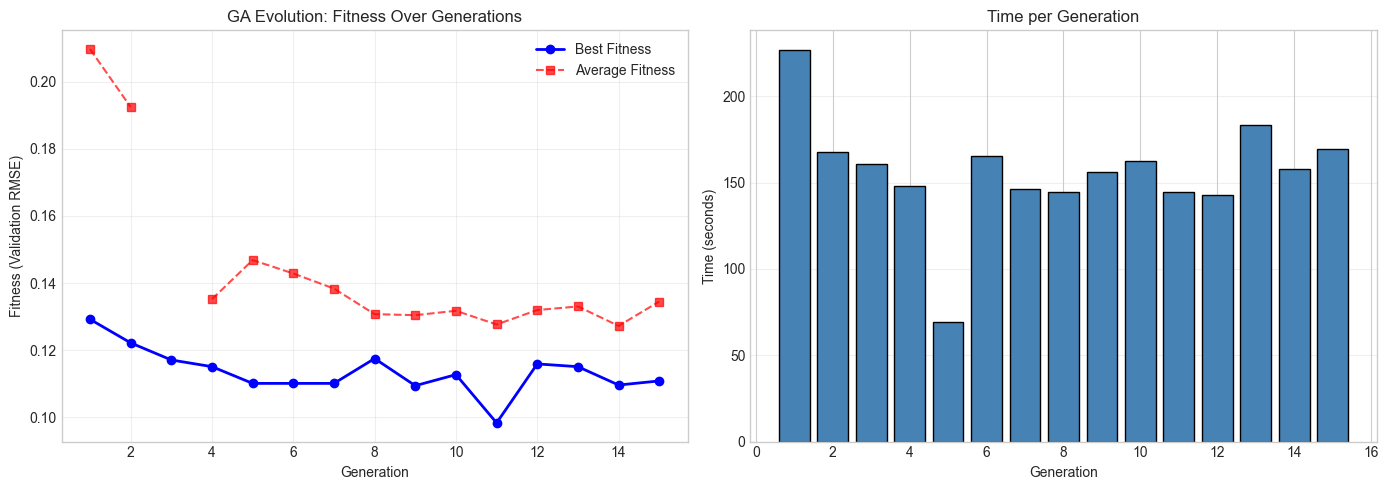


Total optimization time: 2345.42 seconds


In [7]:
# Plot GA evolution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Extract evolution data
generations = [h['generation'] for h in optimization_history]
min_fitness = [h['min_fitness'] for h in optimization_history]
avg_fitness = [h['avg_fitness'] for h in optimization_history]

# Plot fitness over generations
axes[0].plot(generations, min_fitness, 'b-', marker='o', label='Best Fitness', lw=2)
axes[0].plot(generations, avg_fitness, 'r--', marker='s', label='Average Fitness', lw=1.5, alpha=0.7)
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Fitness (Validation RMSE)')
axes[0].set_title('GA Evolution: Fitness Over Generations')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot generation time
gen_times = [h['generation_time'] for h in optimization_history]
axes[1].bar(generations, gen_times, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Generation')
axes[1].set_ylabel('Time (seconds)')
axes[1].set_title('Time per Generation')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nTotal optimization time: {optimizer.total_time:.2f} seconds")

## 5. Train Final Model with Best Hyperparameters

In [8]:
# Train final model with best hyperparameters
final_model, ga_results = optimizer.train_best_model(X_test, y_test)


[INFO] Training final model with best hyperparameters...
Epoch 1/73
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.4266 - mae: 0.9219 - val_loss: 0.7597 - val_mae: 0.7059
Epoch 2/73
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7854 - mae: 0.6936 - val_loss: 0.5152 - val_mae: 0.5701
Epoch 3/73
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4953 - mae: 0.5416 - val_loss: 0.4112 - val_mae: 0.5060
Epoch 4/73
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3498 - mae: 0.4616 - val_loss: 0.3415 - val_mae: 0.4485
Epoch 5/73
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2752 - mae: 0.4070 - val_loss: 0.3035 - val_mae: 0.4218
Epoch 6/73
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2246 - mae: 0.3648 - val_loss: 0.2064 - val_mae: 0.3360
Epoch 7/73
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2013 - mae: 0.3388 - val_loss: 0.2092 - val_mae: 0.3440
Epoch 8/73
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1723 - mae: 0.3111 - val_loss: 0.1072 - val_mae: 0.2418
Epoch 9/73
21

In [9]:
# Make predictions
y_pred_test = final_model.predict(X_test, verbose=0).flatten()

# Inverse transform
y_test_orig = inverse_transform_predictions(y_test, data['target_scaler'])
y_pred_test_orig = inverse_transform_predictions(y_pred_test, data['target_scaler'])

## 6. Model Evaluation

In [10]:
# Evaluate
test_metrics = evaluate_model(
    y_test_orig, y_pred_test_orig,
    'GA-ANN',
    training_time=ga_results['training_time']
)

print("="*60)
print("GA-OPTIMIZED ANN EVALUATION RESULTS")
print("="*60)
print(f"\nTest Set:")
print(f"  RMSE: {test_metrics['rmse']:.4f}")
print(f"  MAE:  {test_metrics['mae']:.4f}")
print(f"  R²:   {test_metrics['r2']:.4f}")
print(f"\nTime Breakdown:")
print(f"  Optimization Time: {optimizer.total_time:.2f}s")
print(f"  Final Training Time: {ga_results['training_time']:.2f}s")
print(f"  Total Time: {ga_results['total_time']:.2f}s")
print("="*60)

GA-OPTIMIZED ANN EVALUATION RESULTS

Test Set:
  RMSE: 1.0232
  MAE:  0.6608
  R²:   0.9838

Time Breakdown:
  Optimization Time: 2345.42s
  Final Training Time: 11.81s
  Total Time: 2357.23s


## 7. Visualizations

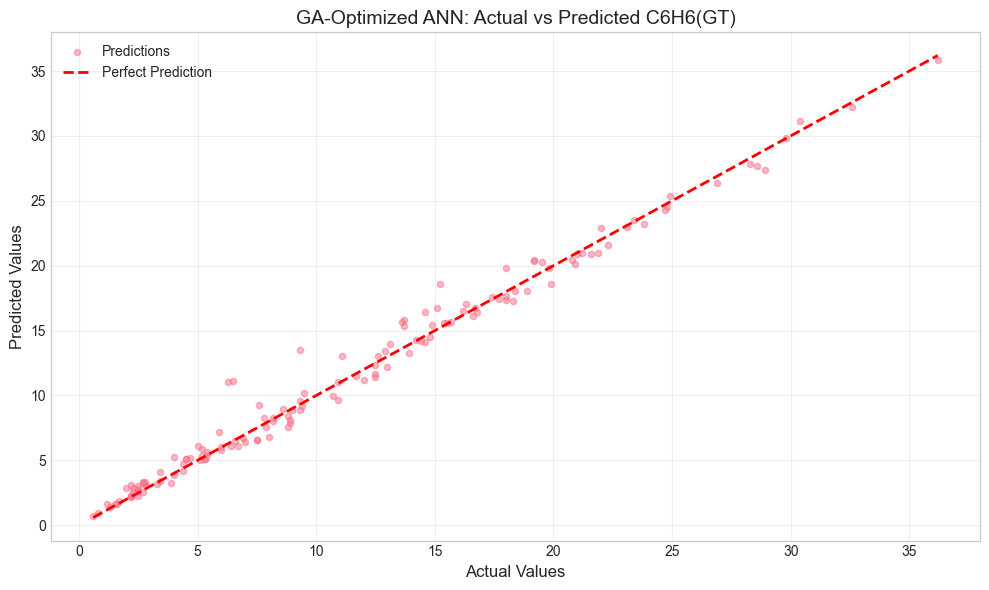

In [11]:
# Actual vs Predicted
fig = plot_actual_vs_predicted(
    y_test_orig, y_pred_test_orig,
    model_name='GA-ANN',
    title=f'GA-Optimized ANN: Actual vs Predicted {TARGET_COLUMN}'
)
plt.show()

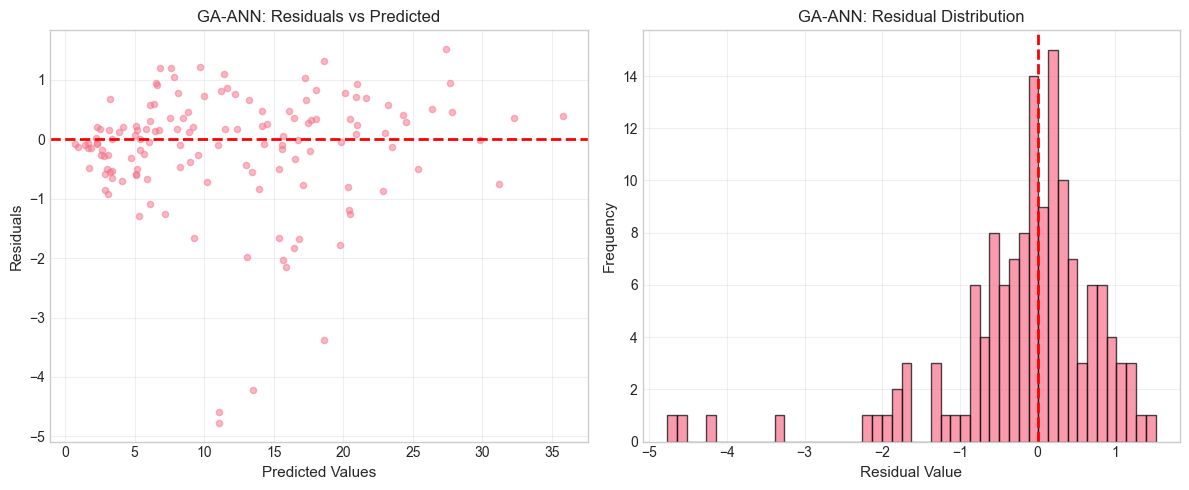

In [12]:
# Residual analysis
fig = plot_residuals(y_test_orig, y_pred_test_orig, model_name='GA-ANN')
plt.show()

Plotting last 139 test samples (total test samples: 139)


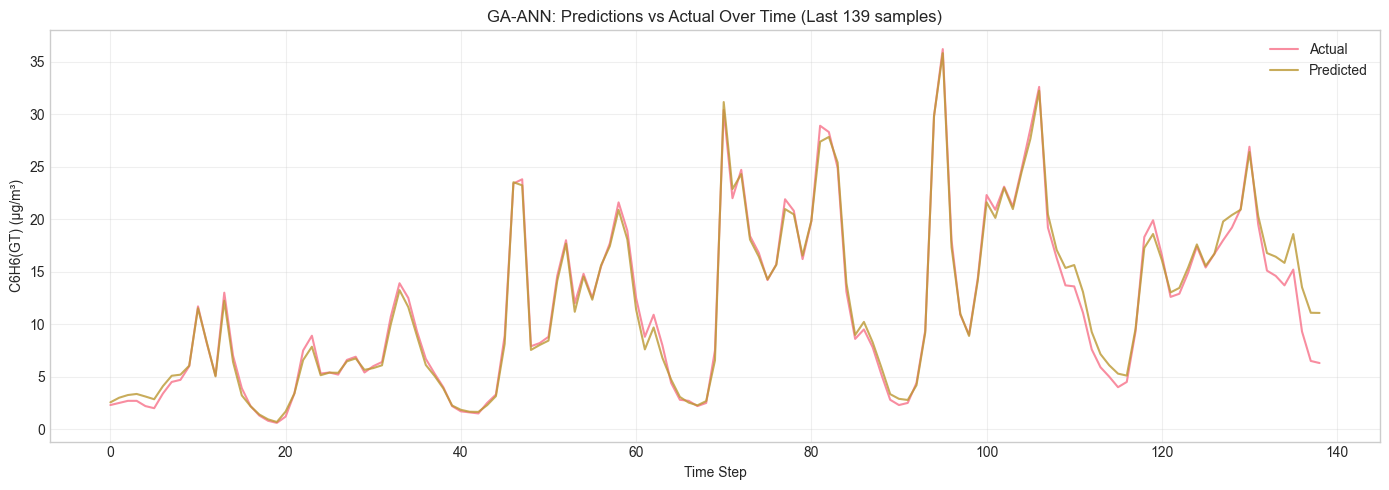

In [14]:
# Predictions over time (fixed to handle small test sets)
n_points = min(200, len(y_test_orig))  # Don't exceed available data

print(f"Plotting last {n_points} test samples (total test samples: {len(y_test_orig)})")

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(range(n_points), y_test_orig[-n_points:], label='Actual', alpha=0.8, lw=1.5)
ax.plot(range(n_points), y_pred_test_orig[-n_points:], label='Predicted', alpha=0.8, lw=1.5)
ax.set_xlabel('Time Step')
ax.set_ylabel(f'{TARGET_COLUMN} (µg/m³)')
ax.set_title(f'GA-ANN: Predictions vs Actual Over Time (Last {n_points} samples)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Save Results

In [15]:
# Compile results
ga_ann_results = {
    'model_type': 'GA-ANN',
    'ga_config': GA_CONFIG,
    'best_params': best_params,
    'search_space': {
        'learning_rate': bounds.learning_rate_bounds,
        'neurons_layer1': bounds.neurons_layer1_bounds,
        'neurons_layer2': bounds.neurons_layer2_bounds,
        'epochs': bounds.epochs_bounds,
        'dropout': bounds.dropout_bounds
    },
    'metrics': {'test': test_metrics},
    'optimization_time': optimizer.total_time,
    'training_time': ga_results['training_time'],
    'total_time': ga_results['total_time'],
    'optimization_history': [
        {
            'generation': h['generation'],
            'min_fitness': h['min_fitness'],
            'avg_fitness': h['avg_fitness']
        } for h in optimization_history
    ],
    'predictions': {
        'test_actual': y_test_orig.tolist(),
        'test_predicted': y_pred_test_orig.tolist()
    }
}

# Save to JSON
save_results_to_json(ga_ann_results, '../results/ga_ann_results.json')

print("Results saved successfully!")

[INFO] Results saved to ../results/ga_ann_results.json
Results saved successfully!


## 9. Summary and Discussion

### Hybrid CI Approach Analysis:

#### GA Contribution:
- Explored hyperparameter space systematically
- Found non-obvious parameter combinations
- Avoided manual trial-and-error

#### Trade-offs:
| Aspect | Manual Tuning | GA Optimization |
|--------|---------------|------------------|
| Time | Variable | Higher (many trainings) |
| Quality | Depends on expertise | Systematic search |
| Reproducibility | Low | High |
| Exploration | Limited | Comprehensive |

### Key Observations:
1. **Optimized Learning Rate**: GA found effective learning rate
2. **Network Size**: Balance between capacity and overfitting
3. **Regularization**: Appropriate dropout for generalization

### CI Academic Significance:
This hybrid approach demonstrates:
- Integration of multiple CI paradigms
- Meta-optimization (using CI to optimize CI)
- Practical application of evolutionary computation

In [16]:
# Final summary
print("\n" + "="*60)
print("GA-OPTIMIZED ANN SUMMARY")
print("="*60)
print(f"\nOptimized Architecture:")
print(f"  Input -> {best_params['neurons_layer1']} -> {best_params['neurons_layer2']} -> Output")
print(f"  Learning Rate: {best_params['learning_rate']:.6f}")
print(f"  Dropout: {best_params['dropout_rate']:.2f}")
print(f"  Epochs: {best_params['epochs']}")
print(f"\nPerformance:")
print(f"  Test RMSE: {test_metrics['rmse']:.4f}")
print(f"  Test MAE: {test_metrics['mae']:.4f}")
print(f"  Test R²: {test_metrics['r2']:.4f}")
print(f"\nComputational Cost:")
print(f"  GA Optimization: {optimizer.total_time:.2f}s")
print(f"  Generations: {GA_CONFIG['n_generations']}")
print(f"  Population: {GA_CONFIG['population_size']}")
print("="*60)


GA-OPTIMIZED ANN SUMMARY

Optimized Architecture:
  Input -> 104 -> 49 -> Output
  Learning Rate: 0.003455
  Dropout: 0.29
  Epochs: 73

Performance:
  Test RMSE: 1.0232
  Test MAE: 0.6608
  Test R²: 0.9838

Computational Cost:
  GA Optimization: 2345.42s
  Generations: 15
  Population: 20
